In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [14]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
def compute_SMA(series, window=7):
    return series.rolling(window=window).mean()

def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_stochastic_oscillator(high, low, close, window=14):
    lowest_low = low.rolling(window=window).min()
    highest_high = high.rolling(window=window).max()
    stoch = 100 * (close - lowest_low) / (highest_high - lowest_low)
    return stoch

In [16]:
train_path = "AUD_USD_Historical_Data_TRAIN.csv"
test_path  = "AUD_USD_Historical_Data_TEST.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Convert Date column to datetime (format is DD/MM/YYYY)
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%d/%m/%Y')
test_df['Date']  = pd.to_datetime(test_df['Date'], format='%d/%m/%Y')

# Sort by date to ensure proper time ordering
train_df.sort_values('Date', inplace=True)
test_df.sort_values('Date', inplace=True)

# Remove the '%' sign from "Change %" and convert to float
for df in [train_df, test_df]:
    df['Change %'] = df['Change %'].str.rstrip('%').astype(float)

# Compute technical indicators on each dataset
for df in [train_df, test_df]:
    df['SMA'] = compute_SMA(df['Open'], window=7)
    df['RSI'] = compute_RSI(df['Open'], window=14)
    df['Stoch'] = compute_stochastic_oscillator(df['High'], df['Low'], df['Open'], window=14)

# Drop rows with NaN values that result from indicator calculations
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Define features and target.
# The target is "Open" while all other columns (except Date) are used as features.
feature_cols = ['Price', 'Open', 'High', 'Low', 'Change %', 'SMA', 'RSI', 'Stoch']
target_col = ['Price']

In [17]:
# Prepare features and target
train_features = train_df[feature_cols]
train_target = train_df[target_col]
test_features = test_df[feature_cols]
test_target = test_df[target_col]

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(train_features)
train_features_scaled = scaler_X.transform(train_features)
test_features_scaled = scaler_X.transform(test_features)

scaler_y.fit(train_target)
train_target_scaled = scaler_y.transform(train_target)
test_target_scaled = scaler_y.transform(test_target)

# Create sequences that include current day's opening price
def create_sequences_with_current_open(features, target, seq_length=30, open_index=1):
    xs, current_opens, ys = [], [], []
    for i in range(len(features) - seq_length):
        # Use previous seq_length days as sequence input
        x = features[i:i+seq_length]
        # Get current day's open price (from the prediction day, i+seq_length)
        current_open = features[i+seq_length, open_index]
        y = target[i+seq_length]
        xs.append(x)
        current_opens.append(current_open)
        ys.append(y)
    return np.array(xs), np.array(current_opens).reshape(-1,1), np.array(ys)


seq_length = 30
X_train, train_open, y_train = create_sequences_with_current_open(train_features_scaled, train_target_scaled, seq_length)
X_test, test_open, y_test    = create_sequences_with_current_open(test_features_scaled, test_target_scaled, seq_length)

# Create PyTorch datasets and loaders that now return (historical sequence, current_open, target)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                torch.tensor(train_open, dtype=torch.float32),
                                torch.tensor(y_train, dtype=torch.float32))
test_dataset  = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                torch.tensor(test_open, dtype=torch.float32),
                                torch.tensor(y_test, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
class CNN_RNN(nn.Module):
    def __init__(self, rnn_type='LSTM', num_features=8, cnn_channels=64, kernel_size=3, rnn_hidden=50, num_layers=1):
        super(CNN_RNN, self).__init__()
        # Convolution layer: note that Conv1d expects (batch, channels, seq_length)
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=cnn_channels, 
                               kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        # RNN layer (LSTM or GRU) using cnn_channels as input size
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=cnn_channels, hidden_size=rnn_hidden, 
                               num_layers=num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=cnn_channels, hidden_size=rnn_hidden, 
                              num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("Unsupported rnn_type. Use 'LSTM' or 'GRU'")
        # Process current open price: map scalar -> feature vector (size 10 is arbitrary)
        self.fc_open = nn.Linear(1, 10)
        # Combine the RNN output with the processed open price
        self.fc_combined = nn.Linear(rnn_hidden + 10, 1)

    def forward(self, seq, current_open):
        # seq: (batch, seq_length, num_features)
        # current_open: (batch, 1)
        # Rearrange sequence for convolution: (batch, num_features, seq_length)
        x = seq.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        # Rearrange back for RNN: (batch, seq_length, cnn_channels)
        x = x.permute(0, 2, 1)
        # Process sequence through RNN (we ignore hidden states here)
        rnn_out, _ = self.rnn(x)
        # Use the output at the last time step
        rnn_feat = rnn_out[:, -1, :]  # shape: (batch, rnn_hidden)
        # Process current open price
        open_feat = self.fc_open(current_open)  # shape: (batch, 10)
        # Concatenate the RNN features with open_feat
        combined = torch.cat([rnn_feat, open_feat], dim=1)  # shape: (batch, rnn_hidden + 10)
        out = self.fc_combined(combined)
        return out


In [19]:
num_features = len(feature_cols)

model_lstm = CNN_RNN(rnn_type='LSTM', num_features=num_features).to(device)
model_gru  = CNN_RNN(rnn_type='GRU',  num_features=num_features).to(device)

In [20]:

def train_model(model, train_loader, num_epochs=50, lr=1e-3, criterion=nn.MSELoss()):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_seq, batch_open, batch_y in train_loader:
            batch_seq = batch_seq.to(device)
            batch_open = batch_open.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_seq, batch_open)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}")


In [21]:
print("Training CNN-LSTM model")
train_model(model_lstm, train_loader, num_epochs=50, lr=1e-3, criterion=nn.MSELoss())

print("\nTraining CNN-GRU model")
train_model(model_gru, train_loader, num_epochs=50, lr=1e-3, criterion=nn.MSELoss())

Training CNN-LSTM model
Epoch 5/50, Loss: 0.0021
Epoch 10/50, Loss: 0.0019
Epoch 15/50, Loss: 0.0021
Epoch 20/50, Loss: 0.0019
Epoch 25/50, Loss: 0.0019
Epoch 30/50, Loss: 0.0018
Epoch 35/50, Loss: 0.0019
Epoch 40/50, Loss: 0.0019
Epoch 45/50, Loss: 0.0018
Epoch 50/50, Loss: 0.0018

Training CNN-GRU model
Epoch 5/50, Loss: 0.0023
Epoch 10/50, Loss: 0.0021
Epoch 15/50, Loss: 0.0020
Epoch 20/50, Loss: 0.0020
Epoch 25/50, Loss: 0.0020
Epoch 30/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0019
Epoch 40/50, Loss: 0.0018
Epoch 45/50, Loss: 0.0019
Epoch 50/50, Loss: 0.0019


In [22]:
def evaluate_model(model, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_seq, batch_open, batch_y in loader:
            batch_seq = batch_seq.to(device)
            batch_open = batch_open.to(device)
            outputs = model(batch_seq, batch_open)
            predictions.append(outputs.cpu().numpy())
            actuals.append(batch_y.numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return predictions, actuals

# Get predictions on the test set
preds_lstm, actuals = evaluate_model(model_lstm, test_loader)
preds_gru,  actuals = evaluate_model(model_gru, test_loader)  # note: same actuals

# Inverse transform predictions and actuals to original scale (closing prices)
preds_lstm_inv = scaler_y.inverse_transform(preds_lstm)
preds_gru_inv  = scaler_y.inverse_transform(preds_gru)
actuals_inv    = scaler_y.inverse_transform(actuals)

mae_lstm = mean_absolute_error(actuals_inv, preds_lstm_inv)
mse_lstm = mean_squared_error(actuals_inv, preds_lstm_inv)
mae_gru  = mean_absolute_error(actuals_inv, preds_gru_inv)
mse_gru  = mean_squared_error(actuals_inv, preds_gru_inv)

In [23]:
print("\nCNN-LSTM Performance: MAE = {:.4f}, MSE = {:.4f}".format(mae_lstm, mse_lstm))
print("CNN-GRU Performance:  MAE = {:.4f}, MSE = {:.4f}".format(mae_gru, mse_gru))


CNN-LSTM Performance: MAE = 0.0029, MSE = 0.0000
CNN-GRU Performance:  MAE = 0.0029, MSE = 0.0000


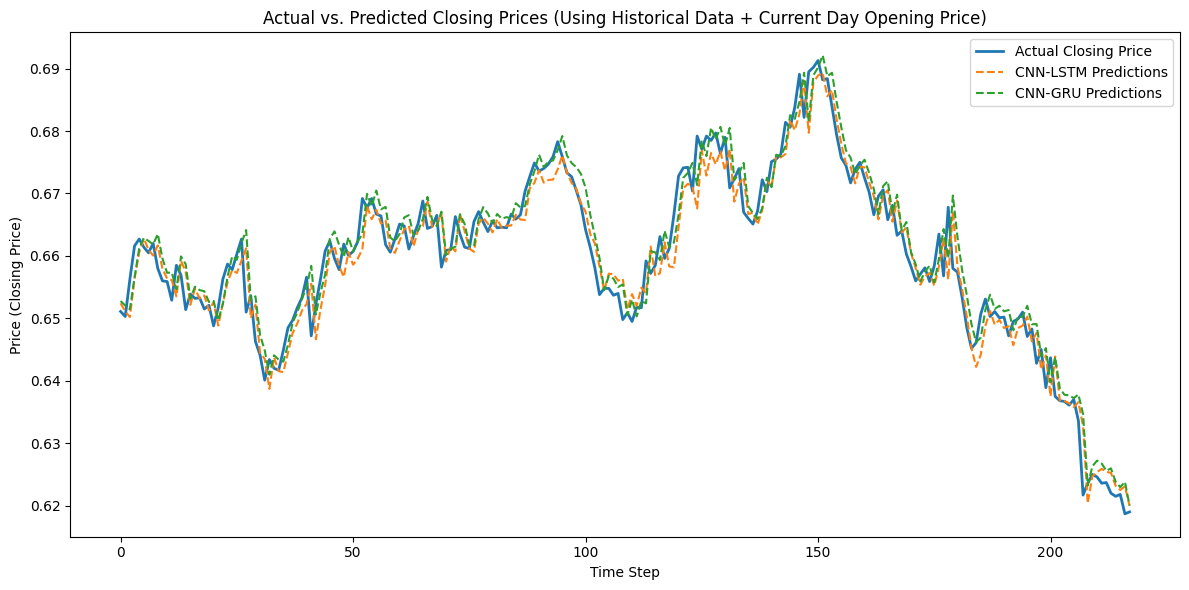

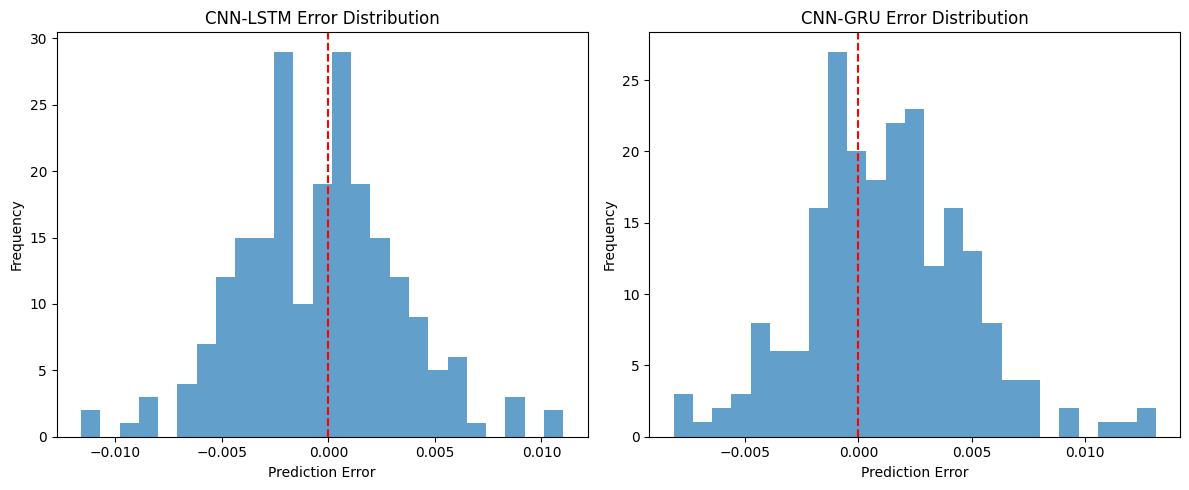

In [24]:
# Create visualizations
plt.figure(figsize=(12,6))
plt.plot(actuals_inv, label='Actual Closing Price', linewidth=2)
plt.plot(preds_lstm_inv, label='CNN-LSTM Predictions', linestyle='--')
plt.plot(preds_gru_inv, label='CNN-GRU Predictions', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Price (Closing Price)')
plt.title('Actual vs. Predicted Closing Prices (Using Historical Data + Current Day Opening Price)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot error distributions
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
lstm_errors = preds_lstm_inv - actuals_inv
plt.hist(lstm_errors, bins=25, alpha=0.7, label='CNN-LSTM Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('CNN-LSTM Error Distribution')

plt.subplot(1,2,2)
gru_errors = preds_gru_inv - actuals_inv
plt.hist(gru_errors, bins=25, alpha=0.7, label='CNN-GRU Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('CNN-GRU Error Distribution')

plt.tight_layout()
plt.show()